# 股吧情绪分析

目标地址

http://guba.eastmoney.com/list,of161725.html


代理池

https://github.com/jhao104/proxy_pool

## 一、导入程序

In [2]:
# import csv
import time
import random
import requests
import traceback
from time import sleep
from fake_useragent import UserAgent
from lxml import etree
import pandas as pd
import re
import math


## 二、程序设计

### 1、数据源获取

> 无限请求，直到请求到数据

In [3]:
# page = 1  #设置爬取的页数
# fundcode = 161725  #可替换任意基金代码
# sleep(random.uniform(1, 2))  #随机出现1-2之间的数，包含小数
# headers = {"User-Agent": UserAgent(verify_ssl=False).random}
# url = f'http://guba.eastmoney.com/list,of{fundcode}_{page}.html'
# response = requests.get(url, headers=headers, timeout=10)
# print(response)


def get_fund_data(fundcode='161725', page=1, proxies=None):
    try:
        # page = 1  #设置爬取的页数
        # fundcode = 161725  #可替换任意基金代码
        sleep(random.uniform(1, 5))  #随机出现1-2之间的数，包含小数
        headers = {"User-Agent": UserAgent().random}
        url = f'http://guba.eastmoney.com/list,of{fundcode}_{page}.html'
        print('开始请求')
        print(url)
        response = requests.get(url, headers=headers, timeout=10, proxies=proxies)
        # print(response)
        return response.text
    except requests.exceptions.ConnectionError:
        t = random.uniform(1, 5)
        print(f'ConnectionError -- please wait {t} seconds')
        time.sleep(random.uniform(1, 5))
        return get_fund_data(fundcode, page, proxies)
    except requests.exceptions.ChunkedEncodingError:
        t = random.uniform(1, 5)
        print(f'ChunkedEncodingError -- please wait {t} seconds')
        time.sleep(t)
        return get_fund_data(fundcode, page, proxies)
    except:
        t = random.uniform(1, 5)
        print(
            f'Unfortunitely -- An Unknow Error Happened, Please wait {t} seconds'
        )
        time.sleep(t)
        return get_fund_data(fundcode, page, proxies)

response = get_fund_data()

开始请求
http://guba.eastmoney.com/list,of161725_1.html


### 2、解析数据

In [4]:
# 获取总页数
def parse_total(html):
    parse = etree.HTML(html)
    # print(etree.tostring(parse))
    div = parse.xpath('//*[@id="articlelistnew"]/div')[-2]
    total = div.text
    # 总共篇数
    total = re.findall(r'(\d+)', total)[0]
    # 总页数, 总篇数/单页条数，再向上取整
    total = math.ceil((int(total) / 80))
    return total

total = parse_total(response)
# etree.tostring(total)
total


9529

In [5]:
# 获取数据源
def parse_fund(html):
    parse = etree.HTML(html)  # 解析网页
    items = parse.xpath('//*[@id="articlelistnew"]/div')[1:-2]
    data = []
    columns = ['阅读', '评论', '标题', '作者', '时间']
    for item in items:
        _arr = [
            ''.join(item.xpath('./span[1]/text()')).strip(),
            ''.join(item.xpath('./span[2]/text()')).strip(),
            ''.join(item.xpath('./span[3]/a/text()')).strip(),
            ''.join(item.xpath('./span[4]/a/font/text()')).strip(),
            ''.join(item.xpath('./span[5]/text()')).strip()
        ]
        # item = {
        #     '阅读': ''.join(item.xpath('./span[1]/text()')).strip(),
        #     '评论': ''.join(item.xpath('./span[2]/text()')).strip(),
        #     '标题': ''.join(item.xpath('./span[3]/a/text()')).strip(),
        #     '作者': ''.join(item.xpath('./span[4]/a/font/text()')).strip(),
        #     '时间': ''.join(item.xpath('./span[5]/text()')).strip()
        # }
        data.append(_arr)
        # print(item)
    # print(arr)
    df = pd.DataFrame(data=data,columns=columns)
    return df
df = parse_fund(response)
df

,阅读,评论,标题,作者,时间
0,1089,1,【有机会瓜分66666积分】这个中秋，与德邦共赴“飞花,德邦基金,09-10 19:07
1,1270,11,有奖聊 | 那些年我们一起用过的电池,嘉实基金,09-10 19:50
2,11269,20,【有机会瓜分3000壕礼】神仙智能家电大种草！,富国基金,09-10 18:54
3,3787,69,【3000元京东卡】全能成长猎手钟帅重磅新基来袭！记得,华夏基金,09-10 19:17
4,2100,30,有奖互动 | 月圆邀桃“礼” 富达递师恩,富达国际,09-10 17:41
...,...,...,...,...,...
80,2512,3,医药，互联网，新能源传利好，白酒利空，抄底该如何选,大眼海豚,09-10 20:09
81,1172,2,下周走势研究分析，煤炭看量能，白酒博弈中秋行情。,星期五的大平,09-10 20:09
82,244,1,今年一共就涨两个月，到目前为止整整跌了七个月,ckiiii,09-10 20:09
83,10509,20,银行、证券、白酒、医药、新能源、半导体板块走势技术,野庄炖基,09-10 20:09


### 3、保存到csv

In [6]:
df.to_csv('股吧情绪分析.csv', index=False)

## 三、设计主函数

### 1、添加代理池

参考：https://github.com/jhao104/proxy_pool

In [7]:

def get_proxy():
    return requests.get("http://demo.spiderpy.cn/get/").json()


def delete_proxy(proxy):
    requests.get(f"http://demo.spiderpy.cn/delete/?proxy={proxy}")

### 2、设计分页异常函数

In [10]:
proxyObj = get_proxy()
proxy = proxyObj.get("proxy")
region = proxyObj.get('region')
proxies = { "http": f"http://{proxy}" }
print(f'代理:{proxy}, 位置:{region}')

def main(fundcode='161725', page = 1, total=None):
    # try:
    html = get_fund_data(fundcode, page, proxies)
    df = pd.DataFrame()
    if total is None:
        total = parse_total(html)
    print(f'第{page}页/总页数: {total}')
    for page_i in range(page, total):
        # 一定要加随机时间，防止被反爬
        # time.sleep(random.uniform(1, 5))
        if page != 1:
            html = get_fund_data(fundcode, page_i, proxies)
            df = parse_fund(html)
        df = parse_fund(html)
        # 数据为空的情况
        if df.empty is True:
            # 数据为空，重新执行
            main(fundcode, page, total)
        print(f'获取第{page_i}页数据内容')
        print(df)
        df.to_csv('./股吧情绪分析.csv', mode='a', index=False, header=False)
        print(f'第{page_i}页数据内容保存成功!')
    # except Exception as e:
    #     print(e)
    #     print(f'第{page}页有异常，正在重新请求..')
    # main(fundcode, page, total)
main()

代理:20.187.70.249:8000, 位置:中国 香港  microsoft.com


## 四、可视化

### 1、导入数据

In [84]:
df = pd.read_csv("股吧情绪分析.csv")
                #  names=['阅读', '评论', '标题', '作者', '时间'],
                
df
# df['时间'] = df['时间'].apply(lambda x: x+1)
# df['阅读'] = df['阅读'].str.replace('万','').astype('float')
# df['时间'] = pd.to_datetime(df['时间'],errors='ignore') 

,阅读,评论,标题,作者,时间
0,1089,1,【有机会瓜分66666积分】这个中秋，与德邦共赴“飞花,德邦基金,09-10 19:07
1,1270,11,有奖聊 | 那些年我们一起用过的电池,嘉实基金,09-10 19:50
2,11269,20,【有机会瓜分3000壕礼】神仙智能家电大种草！,富国基金,09-10 18:54
3,3787,69,【3000元京东卡】全能成长猎手钟帅重磅新基来袭！记得,华夏基金,09-10 19:17
4,2100,30,有奖互动 | 月圆邀桃“礼” 富达递师恩,富达国际,09-10 17:41
...,...,...,...,...,...
815060,11953,75,全职炒股第四年，关于投资最骗人的几句话,趋势价投禾木客,09-10 20:09
815061,9153,66,下周随时可能确认中线买点,熙凤吖,09-10 20:09
815062,1535,2,对话基金经理张西林：用溯因法去理解市场，理解了“因,招商基金,09-10 20:09
815063,2513,3,医药，互联网，新能源传利好，白酒利空，抄底该如何选,大眼海豚,09-10 20:09


### 2、数据清洗

In [85]:
#重复和缺失数据
df = df.drop_duplicates()
df = df.dropna()

#数据类型转换
# df['阅读'] = df['阅读'].str.replace('万','').astype('float')
df['阅读'] = df['阅读'].astype('float')
# df['时间'] = pd.to_datetime(df['时间'],errors='ignore') 

#机械压缩去重
def yasuo(st):
    for i in range(1,int(len(st)/2)+1):
        for j in range(len(st)):
            if st[j:j+i] == st[j+i:j+2*i]:
                k = j + i
                while st[k:k+i] == st[k+i:k+2*i] and k<len(st):   
                    k = k + i
                st = st[:j] + st[k:]    
    return st
yasuo(st="J哥J哥J哥J哥J哥")
df["标题"] = df["标题"].apply(yasuo)

#过滤表情
df['标题'] = df['标题'].str.extract(r"([\u4e00-\u9fa5]+)")
df = df.dropna()  #纯表情直接删除

#过滤短句
# df = df[df["标题"].apply(len)>=3]
df = df.dropna()
df

,阅读,评论,标题,作者,时间
0,1089.0,1,有机会瓜分,德邦基金,09-10 19:07
1,1270.0,11,有奖聊,嘉实基金,09-10 19:50
2,11269.0,20,有机会瓜分,富国基金,09-10 18:54
3,3787.0,69,元京东卡,华夏基金,09-10 19:17
4,2100.0,30,有奖互动,富达国际,09-10 17:41
...,...,...,...,...,...
12391,180.0,2,完了呀,乐在知足1990,09-10 20:11
12398,15328.0,24,复盘,小高理财吖,09-10 20:09
12402,3290.0,13,策略,龙行天下虎呀,09-10 20:09
12406,9153.0,66,下周随时可能确认中线买点,熙凤吖,09-10 20:09


In [88]:
df['时间'] = df['时间'].apply(lambda x: f'2022-{x}')

# df['时间'] = pd.to_datetime(df['时间'],errors='ignore') 

# df.set_index('时间', drop=True)


,阅读,评论,标题,作者,时间
0,1089.0,1,有机会瓜分,德邦基金,2022-09-10 19:07
1,1270.0,11,有奖聊,嘉实基金,2022-09-10 19:50
2,11269.0,20,有机会瓜分,富国基金,2022-09-10 18:54
3,3787.0,69,元京东卡,华夏基金,2022-09-10 19:17
4,2100.0,30,有奖互动,富达国际,2022-09-10 17:41
...,...,...,...,...,...
12391,180.0,2,完了呀,乐在知足1990,2022-09-10 20:11
12398,15328.0,24,复盘,小高理财吖,2022-09-10 20:09
12402,3290.0,13,策略,龙行天下虎呀,2022-09-10 20:09
12406,9153.0,66,下周随时可能确认中线买点,熙凤吖,2022-09-10 20:09


### 3、制作词云

['机会', '瓜分', '有奖', '机会', '瓜分', '京东', '有奖', '互动', '医疗', '利好', '来袭', '超级', '风暴', '全球', '突发', '重磅', '美股', '大跳水', '好消息', '重磅', '分享', '早评', '消息面', '临近', '黎明前', '被套', '感谢', '小高', '盘中', '分析', '猴哥', '午评', '乐观', '起飞', '加仓', '白酒', '不要脸', '发过', '毒誓', '不进', '白酒', '盘中', '分析', '新能源', '高度', '敬畏', '白酒', '生命线', '已破', '复盘', '红灯笼', '周五', '高挂', '重磅', '美股', '暴力', '上涨', '中国', '首富', '换人', '经理', '白酒', '医药', '白酒', '杀猪', '太难', '上周', '大盘', '缩量', '收阴', '白酒', '回本', '中秋', '盘中', '分析', '医疗', '白酒', '垃圾', '中国', '首富', '换人', '晚谈', '招商', '基金', '侯昊', '中秋', '另类', '祝福', '不到', '几毛', '算账', '下午', '反弹', '中秋', '国庆', '快到', '垃圾', '无法形容', '白酒', '大跌', '原因', '找到', '白酒', '人太多', '亏近', '白酒', '天理难容', '行情', '真差', '告诫', '身边', '朋友', '赶紧', '逃命', '补仓', '有毒', '物质', '周五', '欧洲', '股市', '大涨', '一早', '任正非', '全职', '炒股', '第四年', '基金', '周评', '美国', '数据', '公布', '茅台', '故乡', '复盘', '基金', '经理', '周应波', '红灯笼', '周末', '高挂', '大米', '策略', '任正非', '美股', '突发', '跳水', '全职', '炒股', '第四年', '下周', '确认', '中线', '买点', '对话', '基金', '经理', '西林', '医药', '下周', '走势', '研究', '分析', '一共', '两

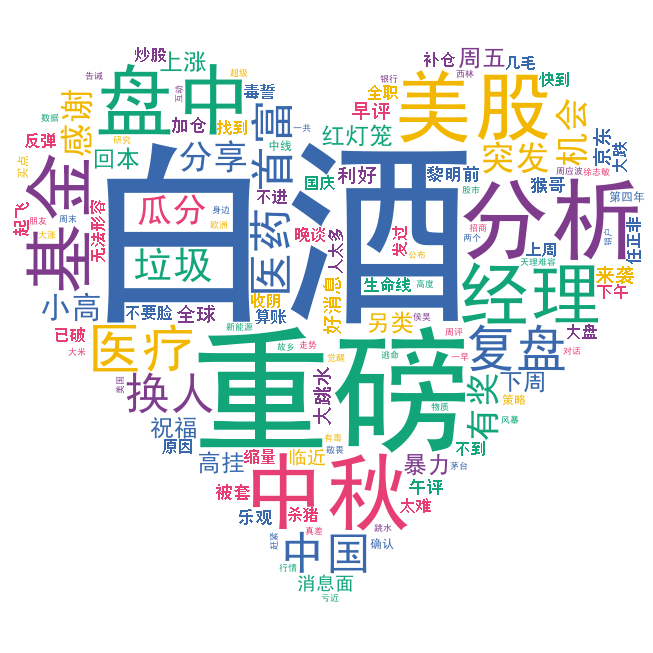

In [69]:
import jieba
import stylecloud
from IPython.display import Image


def get_cut_words(content_series):
    # 读入停用词表
    stop_words = []

    with open("./停用词.txt", 'r', encoding='UTF-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())

    # 添加关键词
    my_words = []
    for i in my_words:
        jieba.add_word(i)

        # 自定义停用词
    my_stop_words = []
    stop_words.extend(my_stop_words)

    # 分词
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)
    # print(word_num)
    # 条件筛选
    word_num_selected = [
        i for i in word_num if i not in stop_words and len(i) >= 2
    ]
    print(word_num_selected)
    return word_num_selected
# jieba.cut(content_)
# 绘制词云图
text1 = get_cut_words(content_series=df['标题'])
stylecloud.gen_stylecloud(text=' '.join(text1), max_words=200,
                          collocations=False,
                          font_path='../SimHei.ttf',
                          icon_name='fas fa-heart',
                          size=653,
                          #palette='matplotlib.Inferno_9',
                          output_name='./基金.png')
Image(filename='./基金.png')


## 五、情绪分析

In [89]:
import paddlehub as hub

# 用在线模型
# senta = hub.Module(name="senta_bilstm")
# 在线模型下载失败，就用本地模型
senta = hub.Module(directory="./senta_bilstm")
texts = df['标题'].tolist()
input_data = {'text': texts}
res = senta.sentiment_classify(data=input_data)
df['投资者情绪'] = [x['positive_probs'] for x in res]
df

[2022-09-11 14:53:44,460] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object
[2022-09-11 14:54:05,166] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


,阅读,评论,标题,作者,时间,投资者情绪
0,1089.0,1,有机会瓜分,德邦基金,2022-09-10 19:07,0.9313
1,1270.0,11,有奖聊,嘉实基金,2022-09-10 19:50,0.6106
2,11269.0,20,有机会瓜分,富国基金,2022-09-10 18:54,0.9313
3,3787.0,69,元京东卡,华夏基金,2022-09-10 19:17,0.1865
4,2100.0,30,有奖互动,富达国际,2022-09-10 17:41,0.8772
...,...,...,...,...,...,...
12391,180.0,2,完了呀,乐在知足1990,2022-09-10 20:11,0.4960
12398,15328.0,24,复盘,小高理财吖,2022-09-10 20:09,0.5741
12402,3290.0,13,策略,龙行天下虎呀,2022-09-10 20:09,0.3768
12406,9153.0,66,下周随时可能确认中线买点,熙凤吖,2022-09-10 20:09,0.7980


### 对数据进行重采样

In [92]:
#重采样至15分钟
# df.dtypes
# df['时间'] = pd.to_datetime(df['时间'])
# df['时间'] = df['时间']
# df.dtypes
# print(df['时间'].dtype)
# df
# df.index = df['时间']
df.index = pd.to_datetime(df['时间'])
df.index
# stock_df = pd.DataFrame(df).set_index('时间')
data = df.resample('15min').mean().reset_index()
# print(data)
# data = df.resample('15min').mean()
data
# data

,时间,阅读,评论,投资者情绪
0,2022-09-10 17:30:00,2100.000000,30.000000,0.877200
1,2022-09-10 17:45:00,NaN,NaN,NaN
2,2022-09-10 18:00:00,NaN,NaN,NaN
3,2022-09-10 18:15:00,NaN,NaN,NaN
4,2022-09-10 18:30:00,NaN,NaN,NaN
5,2022-09-10 18:45:00,11272.000000,20.000000,0.931300
6,2022-09-10 19:00:00,1089.000000,1.000000,0.931300
7,2022-09-10 19:15:00,3789.000000,69.000000,0.186500
8,2022-09-10 19:30:00,NaN,NaN,NaN
9,2022-09-10 19:45:00,1270.500000,11.000000,0.610600


## 六、舆论与股价关联

In [100]:
import akshare as ak
import matplotlib.pyplot as plt
import matplotlib

sz_index = ak.stock_zh_a_minute(symbol='sh000001', period='15', adjust="qfq")
sz_index['日期'] = pd.to_datetime(sz_index['day'])
sz_index['收盘价'] = sz_index['close'].astype('float')
# sz_index
data = data.merge(sz_index, left_on='时间', right_on='日期', how='inner')
# data
matplotlib.use('Qt5Agg')
data.index = data['时间']
data[['投资者情绪', '收盘价']].plot(secondary_y=['close'])
plt.show()

,day,open,high,low,close,volume,日期,收盘价
0,2022-06-14 10:00:00,3223.703,3234.829,3223.703,3226.620,3699185300,2022-06-14 10:00:00,3226.620
1,2022-06-14 10:15:00,3226.761,3244.353,3225.794,3244.353,3150362500,2022-06-14 10:15:00,3244.353
2,2022-06-14 10:30:00,3244.468,3245.432,3234.934,3234.934,2122559400,2022-06-14 10:30:00,3234.934
3,2022-06-14 10:45:00,3235.248,3241.134,3225.936,3226.312,2302897000,2022-06-14 10:45:00,3226.312
4,2022-06-14 11:00:00,3225.926,3227.504,3213.588,3215.893,2671379900,2022-06-14 11:00:00,3215.893
...,...,...,...,...,...,...,...,...
1018,2022-09-09 14:00:00,3258.575,3260.805,3257.942,3260.022,968403800,2022-09-09 14:00:00,3260.022
1019,2022-09-09 14:15:00,3260.274,3263.318,3258.941,3261.259,1078111700,2022-09-09 14:15:00,3261.259
1020,2022-09-09 14:30:00,3261.405,3264.730,3259.263,3264.103,1169359300,2022-09-09 14:30:00,3264.103
1021,2022-09-09 14:45:00,3264.040,3266.197,3262.989,3265.516,1531622100,2022-09-09 14:45:00,3265.516
